# **3. Modelos Benchmarks**

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:

# Librerias Importadas
from sklearn.model_selection import learning_curve
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from sklearn.svm import LinearSVR



## **3.1 Enfoque de modelado supervisado**

El objetivo de este estudio es **predecir la cantidad de retiros/redenciones realizados en fondos de inversión colectiva (FIC) y fondos de capital privado (FCP)**, a partir de variables relacionadas con aportes, precios, características de los inversionistas y tipo de entidad.

Se trata de un problema de **regresión supervisada**, en el cual la variable objetivo es continua y corresponde al valor:

$$
\textbf{RETIROS\_REDENCIONES}
$$

El enfoque adoptado es el de **aprendizaje supervisado**, en el cual los modelos aprenden patrones a partir de datos históricos etiquetados para estimar la variable respuesta en nuevos escenarios.

---

✅ **Criterio de evaluación**

La métrica principal para evaluar el desempeño de los modelos es el **coeficiente de determinación $R^2$**. Esta métrica indica qué proporción de la variabilidad de la variable dependiente puede ser explicada por el modelo, y es especialmente útil cuando el objetivo es entender la **capacidad predictiva global** del modelo en comparación con una línea base (media de la variable objetivo).

**¿Por qué se prioriza $R^2$ y no otras métricas como RMSE, MAE o MAPE?**

* $R^2$ permite una **interpretación relativa** del ajuste: un valor cercano a 1 indica que el modelo captura gran parte de la variabilidad.
* A diferencia de métricas absolutas como **RMSE** o **MAE**, que están en las mismas unidades de la variable, el $R^2$ es adimensional, facilitando comparaciones entre modelos y contextos.
* Aunque RMSE y MAE también se reportan, se usan como medidas complementarias para entender la magnitud de los errores.
* La métrica **MAPE** se descarta como principal dado que es inestable cuando hay valores reales cercanos a cero.
* También se incluyen métricas estadísticas como **Jarque-Bera** y **Jung** para validar supuestos de normalidad y homocedasticidad en los residuos.




## **3.2. Preparación y Funciones**

Se importa la base de datos y definimos las variables predictoras y la variable respuesta a usar para los modelos. Luego, dividimos los datos para formar los tres conjuntos necesarios (Entrenamiento, Validación y Prueba).

In [44]:
# Cargar datos
df = pd.read_csv(r'C:\Users\TAWTOCA\OneDrive - Universidad del Norte\Documentos\Visual Folders\Visual Files\Rentabilidad_filtrado.csv')

In [45]:

X = df[["APORTES_RECIBIDOS", "PRECIERRE_FONDO_DIA_T", "TIPO_PARTICIPACION", "NUMERO_INVERSIONISTAS", "TIPO_ENTIDAD"]]
y = df["RETIROS_REDENCIONES"]

# División train-test-validación


X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42)


Se crearon dos diccionarios para optimizar el proceso de entrenamiento de los modelos. El primero son la definición de cada uno de los modelos a utilizar. El segundo, son los posibles hiperparametros, los cuales seran utilizados más adelante al momento de aplicar el RandomizedSearchCV. 

In [46]:
# Diccionario de modelos
modelos = {
    'lineal': LinearRegression(),
    'ridge': Ridge(alpha=1.0),
    'lasso': Lasso(alpha=0.1),
    'knn': KNeighborsRegressor(n_neighbors=5),
    'random_forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'xgboost': XGBRegressor(n_estimators=100, random_state=42),
    'svr': LinearSVR(max_iter=10000, random_state=42)
}

# Diccionario con espacios de hiperparámetros
param_distributions = {
    'lineal': {},  # sin hiperparámetros
    'ridge': {'model__alpha': uniform(0.01, 10)},
    'lasso': {'model__alpha': uniform(0.001, 1)},
    'knn': {
        'model__n_neighbors': randint(5, 30),
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    },
    'random_forest': {
        'model__n_estimators': randint(50, 150),
        'model__max_depth': [10, 20, 30, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    },
    'xgboost': {
        'model__n_estimators': randint(50, 150),
        'model__learning_rate': uniform(0.01, 0.1),
        'model__max_depth': randint(3, 10),
        'model__subsample': uniform(0.7, 0.3),
        'model__colsample_bytree': uniform(0.7, 0.3),
        'model__gamma': uniform(0, 5),
        'model__min_child_weight': randint(1, 10)
    },
    'svr': {
        'model__C': uniform(0.1, 10),
        'model__epsilon': uniform(0.01, 1)
    }
}


La función `entrenar_modelo` se encarga de entrenar un modelo de aprendizaje automático especificado por el parámetro `nombre_modelo` utilizando un conjunto de entrenamiento (`X_train`, `y_train`) y luego evalúa el rendimiento del modelo con un conjunto de prueba (`X_test`, `y_test`). La función permite aplicar una búsqueda de hiperparámetros utilizando `RandomizedSearchCV` si se proporcionan parámetros para el modelo. Además, gestiona modelos que requieren escalado de características (como regresión lineal, Ridge, Lasso, KNN, y SVR) al incluir un escalador en un pipeline. Tras entrenar el modelo, imprime métricas de rendimiento, incluyendo el tiempo de entrenamiento y los valores de R² tanto en el conjunto de entrenamiento como en el de prueba. Si se realizó una búsqueda de hiperparámetros, también muestra los mejores parámetros encontrados.

In [47]:
def entrenar_modelo(nombre_modelo, modelos, param_distributions, X_train, y_train, X_test, y_test, n_iter=10, cv=5):
    modelo = modelos[nombre_modelo]
    params = param_distributions.get(nombre_modelo, {})

    # Incluir modelos que requieren escalado
    modelos_con_escalado = ['lineal', 'ridge', 'lasso', 'knn', 'svr']
    pasos = []

    if nombre_modelo in modelos_con_escalado:
        pasos.append(('scaler', StandardScaler()))
    pasos.append(('model', modelo))

    pipeline = Pipeline(pasos)

    # Si hay hiperparámetros definidos, aplica búsqueda
    if params:
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=params,
            n_iter=n_iter,
            cv=cv,
            scoring='r2',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
    else:
        search = pipeline

    st = time.time()
    search.fit(X_train, y_train)
    et = time.time()

    y_pred = search.predict(X_test)

    print(f"\nModelo: {nombre_modelo}")
    print(f"  Tiempo de entrenamiento: {et - st:.2f} segundos")
    print(f"  Train R²: {search.score(X_train, y_train):.2f}")
    print(f"  Test R²:  {r2_score(y_test, y_pred):.2f}")

    if hasattr(search, 'best_params_'):
        print("  Mejores parámetros:", search.best_params_)

    return search

La función `graficar_curva_aprendizaje` genera una gráfica que muestra cómo varía el rendimiento el modelo (especificado mediante un pipeline) a medida que se incrementa el tamaño del conjunto de entrenamiento. Utiliza validación cruzada con un número de particiones definido por el usuario (`cv`, en este caso 3) y una métrica de evaluación configurable (`scoring`, por defecto `r2`). La función calcula y promedia los puntajes de entrenamiento y validación para distintos tamaños de muestra, y luego los grafica, permitiendo visualizar si el modelo sufre de sobreajuste o subajuste. 


In [48]:
def graficar_curva_aprendizaje(pipeline, X, y, nombre_modelo='modelo', scoring='r2', cv=5):
    """
    Dibuja la curva de aprendizaje del modelo.

    Parámetros:
    - pipeline: pipeline con preprocesamiento y modelo ya definido.
    - X, y: dataset completo.
    - nombre_modelo: nombre del modelo para el título del gráfico.
    - scoring: métrica a usar ('r2', 'neg_mean_squared_error', etc.)
    - cv: número de particiones para validación cruzada.
    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=pipeline,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean,  label='Entrenamiento', color='blue')
    plt.plot(train_sizes, val_scores_mean, label='Validación', color='green')

    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel(scoring.upper())
    plt.title(f"Curva de Aprendizaje - {nombre_modelo}")
    plt.legend()
    plt.tight_layout()
    plt.show()


Las funciones `smape` y `evaluar_metricas` están diseñadas para evaluar el desempeño de los modelos de regresión. La función `smape` (Symmetric Mean Absolute Percentage Error) calcula una métrica porcentual que mide el error relativo entre valores reales y predichos, corrigiendo casos en los que el denominador puede ser cero. Por su parte, `evaluar_metricas` toma un modelo entrenado, datos de entrada y las verdaderas salidas, y calcula diversas métricas: SMAPE, MAE, RMSE (ambas escalables para facilitar la interpretación), el coeficiente de determinación R², y dos pruebas estadísticas sobre los residuos —Ljung-Box para autocorrelación y Jarque-Bera para normalidad—. 

In [49]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator = np.where(denominator == 0, 1e-8, denominator)
    return np.mean(np.abs(y_pred - y_true) / denominator) * 100

def evaluar_metricas(modelo_entrenado, X, y_real, conjunto='Test', escalar=False):
    y_pred = modelo_entrenado.predict(X)

    # SMAPE en vez de MAPE
    smape_val = smape(y_real, y_pred)

    # MAE y RMSE
    mae = mean_absolute_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))

    if escalar:
        divisor = 1e6 if np.abs(rmse) > 1e5 else 1e3 if np.abs(rmse) > 1e3 else 1
        mae /= divisor
        rmse /= divisor
    else:
        divisor = 1

    r2 = r2_score(y_real, y_pred)
    residuales = y_real - y_pred
    ljung_p = acorr_ljungbox(residuales, lags=[10], return_df=True)['lb_pvalue'].values[0]
    jb_p = jarque_bera(residuales)[1]

    # Mostrar métricas
    print(f"\n📊 Métricas para conjunto {conjunto}:")
    print(f"  SMAPE (%):           {smape_val:.2f}")
    print(f"  MAE:                 {mae:.2f}")
    print(f"  RMSE:                {rmse:.2f} {'(millones)' if divisor==1e6 else '(miles)' if divisor==1e3 else ''}")
    print(f"  R²:                  {r2:.4f}")
    print(f"  Ljung-Box p-value:   {ljung_p:.4f}")
    print(f"  Jarque-Bera p-value: {jb_p:.4f}")



---

### ¿Por qué se usa **SMAPE** en lugar de **MAPE**?

* **MAPE (Mean Absolute Percentage Error)** calcula el error porcentual medio, pero **explota o se vuelve indefinido cuando los valores reales se acercan a cero**, lo cual es común y pasa bastante en los datos de la variable respuesta y algunas de las predictoras.
* **SMAPE (Symmetric MAPE)** corrige este problema haciendo el denominador la media absoluta entre predicción y valor real, lo que:

  * Evita divisiones por cero.
  * **Trata los errores relativos de forma más equilibrada**, especialmente en casos con valores muy pequeños (donde un pequeño error absoluto genera un porcentaje exageradamente alto).

---

### ¿Por qué el **MAE** ?

* En este tipo de datos (financieros), **los errores pueden ser naturalmente muy grandes en magnitud debido a la escala**, pero eso **no significa necesariamente que el modelo esté funcionando mal**.
* **MAE (Mean Absolute Error)** es **menos sensible a valores extremos que el RMSE**, lo cual lo hace más estable como métrica secundaria.
* Puede escalarse (por miles o millones) para tener una noción más intuitiva del error promedio.
* Aun así, **tanto SMAPE como MAE pueden parecer "grandes" simplemente porque los valores de la variable objetivo también lo son**.

---
### ¿Por qué **R² (coeficiente de determinación)** es la métrica principal de evaluación?

* R² **no depende directamente de la escala de los datos**, sino de **qué tan bien el modelo explica la variabilidad del objetivo**.derarse **aceptable o bueno** dependiendo del dominio.
* En escenarios con valores extremos y altamente dispersos, como datos financieros:

  * R² es más **interpretativo y comparable entre modelos** que una métrica absoluta como el MAE o RMSE.
  * Permite evaluar la **capacidad explicativa** del modelo sin que los valores monetarios extremos distorsionen la percepción.

---

En resumen, se evita el uso de MAPE porque **no es confiable con valores pequeños**, se prefiere SMAPE y MAE por ser **más robustos y comprensibles**, pero en última instancia se toma el R² como principal métrica porque **es independiente de la escala** y **cuantifica directamente el poder explicativo del modelo**, lo que es especialmente útil cuando los errores absolutos (como 7 mil millones de pesos) pueden parecer grandes, pero no lo son tanto comparados con el rango completo de los datos.


In [50]:
def graficar_diagnostico(modelo_entrenado, X, y_real, nombre_conjunto="Test"):
    """
    Dibuja:
    - Valor real vs. predicción
    - ACF de los residuos con Ljung-Box
    - Histograma de residuos

    Parámetros:
    - modelo_entrenado: modelo o pipeline entrenado
    - X: features
    - y_real: variable objetivo real
    - nombre_conjunto: etiqueta para mostrar en el título
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.stats.diagnostic import acorr_ljungbox

    y_pred = modelo_entrenado.predict(X)
    residuales = y_real - y_pred

    # Ljung-Box
    lb_pvalue = acorr_ljungbox(residuales, lags=[10], return_df=True)['lb_pvalue'].values[0]

    # Gráficos
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Real vs. Predicho con colormap viridis
    scatter = axes[0].scatter(
        y_real, y_pred, c=y_real, cmap='viridis', edgecolor='k', alpha=0.8
    )
    min_val = min(y_real.min(), y_pred.min())
    max_val = max(y_real.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Identidad')
    axes[0].set_title(f'{nombre_conjunto}: Real vs. Predicho')
    axes[0].set_xlabel('Real')
    axes[0].set_ylabel('Predicción')
    axes[0].legend()
    axes[0].grid(True)

    # 2. ACF de los residuos
    plot_acf(residuales, ax=axes[1], lags=40, alpha=0.05)
    axes[1].set_title(f'ACF de residuos\nLjung-Box p-value = {lb_pvalue:.4f}')

    # 3. Histograma de residuos
    sns.histplot(residuales, kde=True, ax=axes[2], bins=30, color=plt.cm.viridis(0.6))
    axes[2].set_title('Histograma de residuos')
    axes[2].set_xlabel('Error')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

La función `graficar_diagnostico` genera un conjunto de tres gráficos complementarios que permiten diagnosticar visualmente el desempeño y la validez del modelo de regresión aplicado a un conjunto de datos (por defecto, el conjunto "Test", pero se pueden utilizar otros como "Train" y "Validation"). A partir de las predicciones del modelo, se calcula el residuo (la diferencia entre los valores reales y predichos), y se usan esos residuos para evaluar tres aspectos clave:

1. **Gráfico Real vs. Predicho**: Este scatter plot muestra la relación entre los valores reales y los valores predichos por el modelo. Se incluye una línea de identidad (diagonal roja discontinua) como referencia ideal; cuanto más se alineen los puntos a esta línea, mejor es el ajuste del modelo. El color de los puntos depende del valor real para dar una idea visual del rango y la distribución.

2. **Función de Autocorrelación (ACF) de los residuos**: Este gráfico ayuda a identificar si los errores del modelo están autocorrelacionados, es decir, si presentan patrones en el tiempo o en el orden de las observaciones. La presencia de autocorrelación puede indicar que el modelo no ha capturado completamente la estructura de los datos. Se complementa con el **p-valor de la prueba de Ljung-Box**, que evalúa si hay autocorrelación significativa en los primeros lags (valores bajos de p indican problemas de independencia en los errores).

3. **Histograma de residuos**: Muestra la distribución de los errores, permitiendo evaluar si los residuos están aproximadamente distribuidos de forma normal (lo cual es deseable en muchos modelos). También incluye una curva de densidad (KDE) para facilitar esta evaluación.


In [51]:

def predecir_y_graficar_por_anio(pipeline_model, X_test, y_test, df_original, columna_fecha="FECHA_CORTE", titulo="Evolución Anual de la Suma"):
    """
    Genera predicciones y grafica la evolución anual (suma por año) de las predicciones vs valores reales.

    Parámetros:
    - pipeline_model: pipeline entrenado.
    - X_test: DataFrame de test con las variables predictoras (ya separado).
    - y_test: Serie con los valores reales (ya separado).
    - df_original: DataFrame original completo que contiene la columna de fecha.
    - columna_fecha: nombre de la columna con la fecha en df_original.
    - titulo: título del gráfico.
    """
    # Obtener los índices de X_test (para alinear fechas)
    indices_test = X_test.index

    # Extraer las fechas correspondientes
    fechas_test = pd.to_datetime(df_original.loc[indices_test, columna_fecha], dayfirst=True, errors='coerce')

    # Extraer año
    anios = fechas_test.dt.year

    # Predecir
    y_pred = pipeline_model.predict(X_test)

    # Crear DataFrame para agrupar
    df_resultados = pd.DataFrame({
        'anio': anios.values,
        'real': y_test.values,
        'prediccion': y_pred
    })

    # Agrupar por año y sumar
    suma_anual = df_resultados.groupby('anio').sum().sort_index()

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.plot(suma_anual.index, suma_anual['real'], 'blue', label='Test')
    plt.plot(suma_anual.index, suma_anual['prediccion'], 'red', label='Predicción')
    plt.title(titulo)
    plt.xlabel("Año")
    plt.ylabel("Suma anual de la variable respuesta")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return suma_anual


In [41]:
import lime.lime_tabular

# ===== Helper para sacar modelo final del pipeline =====
def get_final_model(search_obj):
    if hasattr(search_obj, 'best_estimator_'):
        pipeline = search_obj.best_estimator_
    else:
        pipeline = search_obj
    return pipeline.named_steps['model'], pipeline

## **3.3. Modelos Evaluados**

### *3.3.1. Regresión Lineal*

In [45]:
lineal = entrenar_modelo('lineal', modelos, param_distributions, X_train, y_train, X_test, y_test)


Modelo: lineal
  Tiempo de entrenamiento: 0.13 segundos
  Train R²: 0.73
  Test R²:  0.70


El modelo presenta un rendimiento relativamente estable entre entrenamiento (`R² ≈ 0.72`) y prueba (`R² ≈ 0.70`), lo que indica que no hay overfitting. Aunque el desempeño no es perfecto, el modelo generaliza de forma razonable considerando la alta variabilidad de los datos.

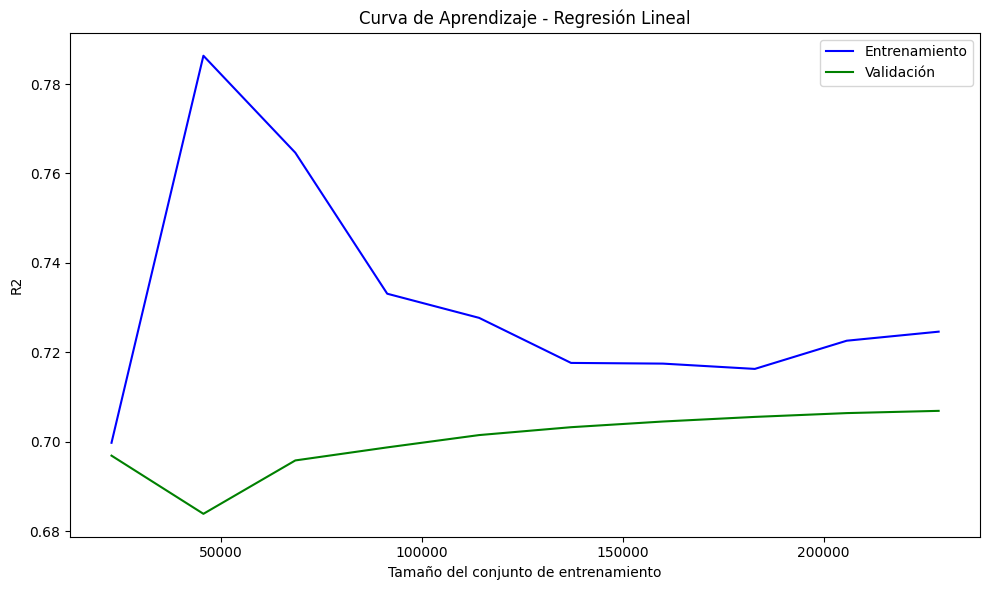

In [33]:
graficar_curva_aprendizaje(lineal, X_train, y_train, nombre_modelo='Regresión Lineal')


In [46]:
evaluar_metricas(lineal, X_test, y_test, conjunto='Test')



📊 Métricas para conjunto Test:
  SMAPE (%):           119.83
  MAE:                 7042472395.87
  RMSE:                23889889083.00 
  R²:                  0.6969
  Ljung-Box p-value:   0.2035
  Jarque-Bera p-value: 0.0000


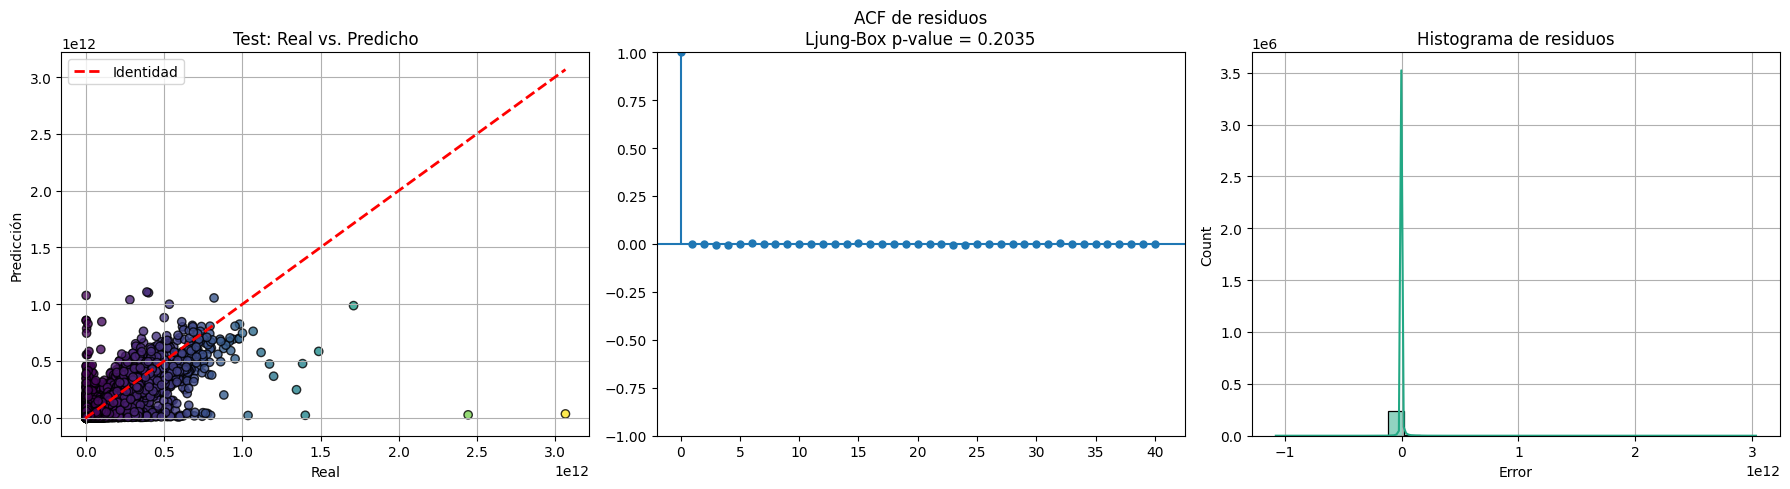

In [47]:
graficar_diagnostico(lineal, X_test, y_test, nombre_conjunto='Test')

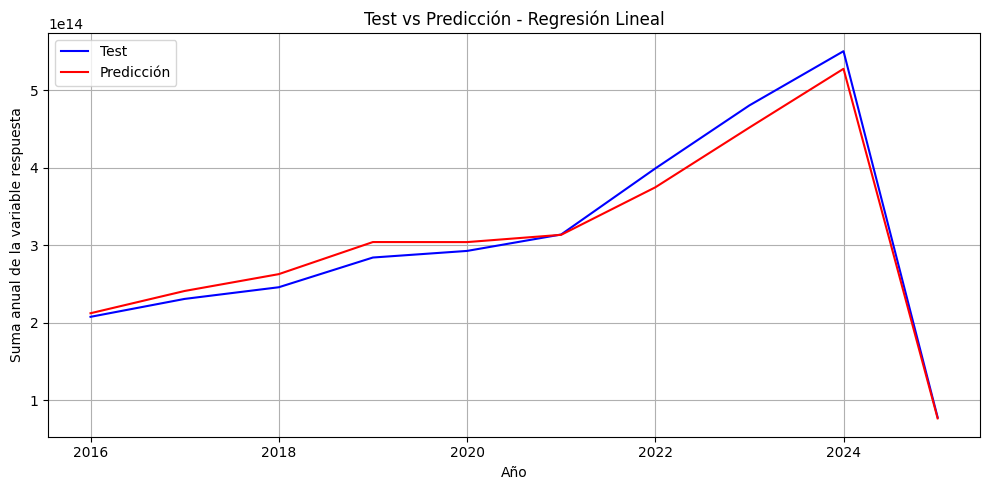

In [34]:
suma_anual = predecir_y_graficar_por_anio(
    pipeline_model=lineal,
    X_test=X_test,
    y_test=y_test,
    df_original=df,
    columna_fecha="FECHA_CORTE",
    titulo="Test vs Predicción - Regresión Lineal"
)


### *3.3.2. Regresión Ridge*

In [49]:
ridge = entrenar_modelo('ridge', modelos, param_distributions, X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Modelo: ridge
  Tiempo de entrenamiento: 9.87 segundos
  Train R²: 0.73
  Test R²:  0.70
  Mejores parámetros: {'model__alpha': np.float64(9.51714306409916)}


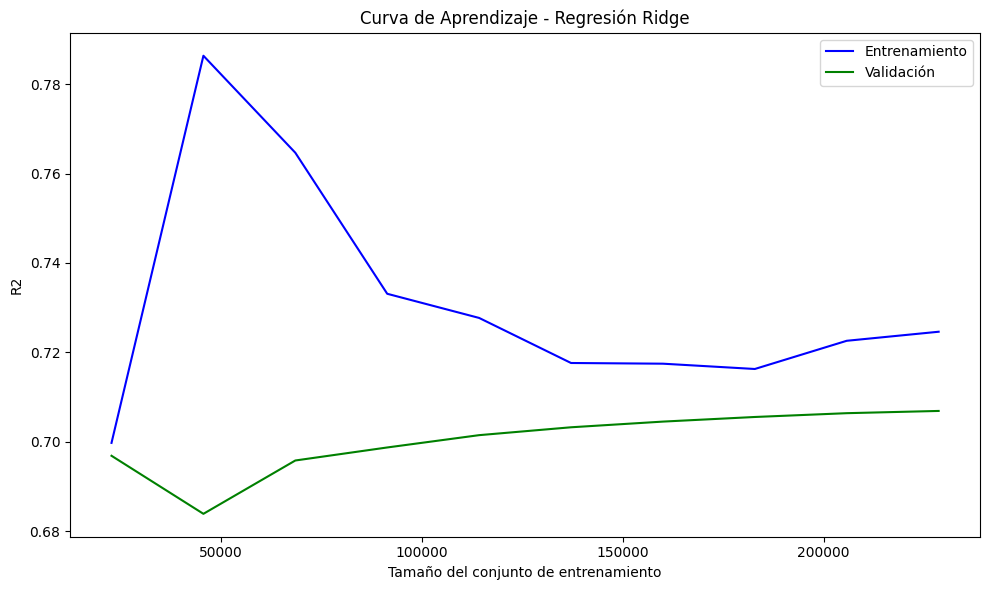

In [35]:
graficar_curva_aprendizaje(ridge, X_train, y_train, nombre_modelo='Regresión Ridge')


La curva naranja (validación) muestra una mejora leve y progresiva del R² a medida que se incrementa el tamaño del conjunto de entrenamiento, estabilizándose alrededor de 0.70. Esto sugiere que el modelo se beneficia ligeramente al entrenar con más datos, aunque los beneficios se van reduciendo.

In [51]:
evaluar_metricas(ridge, X_test, y_test, conjunto='Test')


📊 Métricas para conjunto Test:
  SMAPE (%):           119.83
  MAE:                 7042604283.55
  RMSE:                23889848771.95 
  R²:                  0.6969
  Ljung-Box p-value:   0.2035
  Jarque-Bera p-value: 0.0000


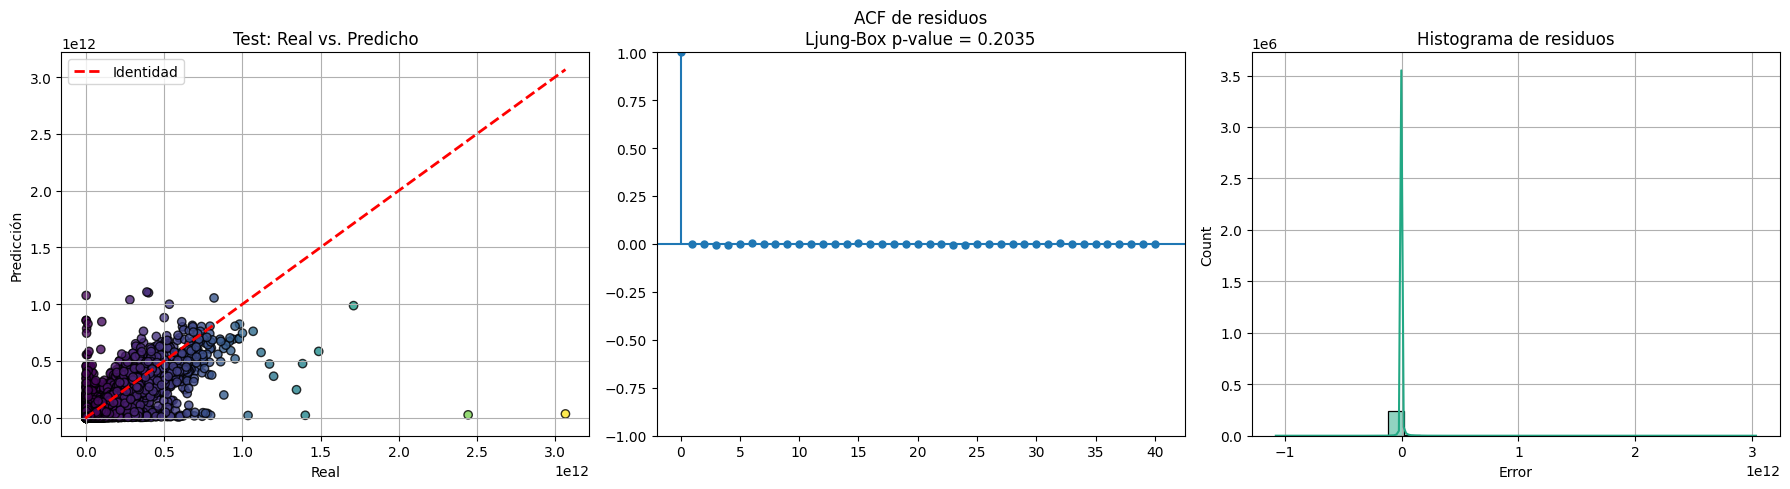

In [52]:
graficar_diagnostico(ridge, X_test, y_test, nombre_conjunto='Test')

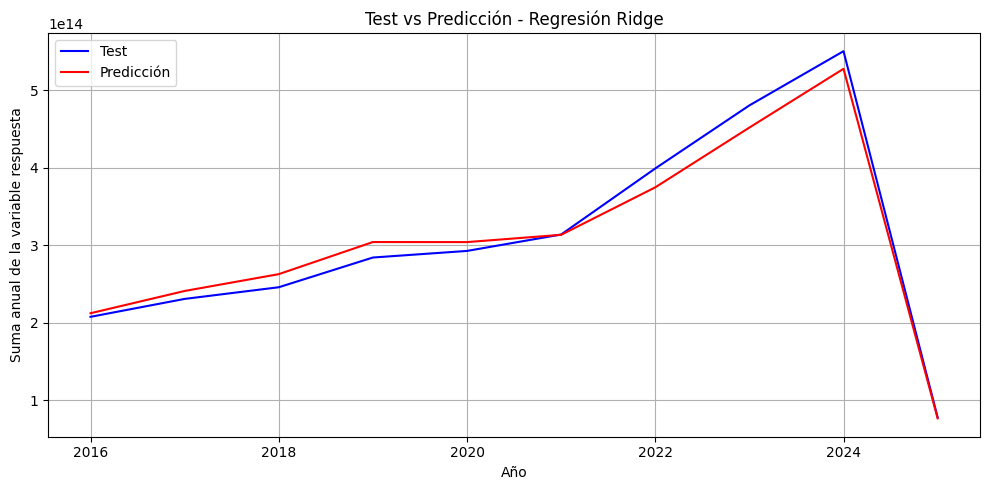

In [36]:
suma_anual = predecir_y_graficar_por_anio(
    pipeline_model=ridge,
    X_test=X_test,
    y_test=y_test,
    df_original=df,
    columna_fecha="FECHA_CORTE",
    titulo="Test vs Predicción - Regresión Ridge"
)


### *3.3.3. Regresión Lasso*

In [54]:
# Entrenar modelo Lasso
lasso = entrenar_modelo('lasso', modelos, param_distributions, X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Modelo: lasso
  Tiempo de entrenamiento: 14.30 segundos
  Train R²: 0.73
  Test R²:  0.70
  Mejores parámetros: {'model__alpha': np.float64(0.9517143064099162)}


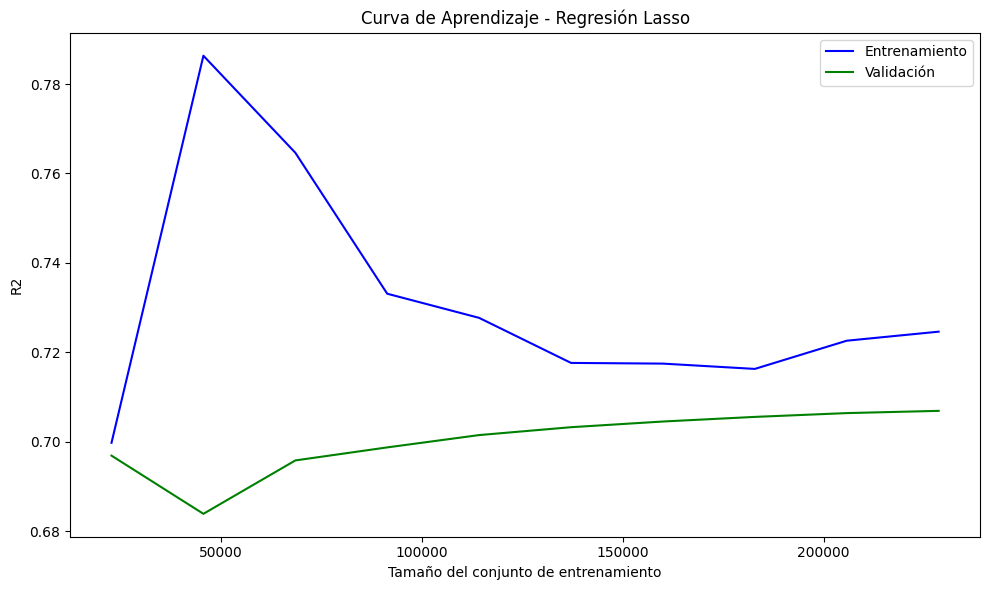

In [32]:
graficar_curva_aprendizaje(lasso, X_train, y_train, nombre_modelo='Regresión Lasso')


In [56]:
evaluar_metricas(lasso, X_test, y_test, conjunto='Test')


📊 Métricas para conjunto Test:
  SMAPE (%):           119.83
  MAE:                 7042472395.58
  RMSE:                23889889083.03 
  R²:                  0.6969
  Ljung-Box p-value:   0.2035
  Jarque-Bera p-value: 0.0000


Las métricas como MAE (~7.1 mil millones) y RMSE (~24 mil millones) reflejan errores absolutos muy altos. Sin embargo, esto es esperable dado el rango de los valores objetivo (hasta 200 billones). En este contexto, estas métricas absolutas pueden parecer desproporcionadas, por lo que se prefiere una métrica relativa como R² para evaluar desempeño.

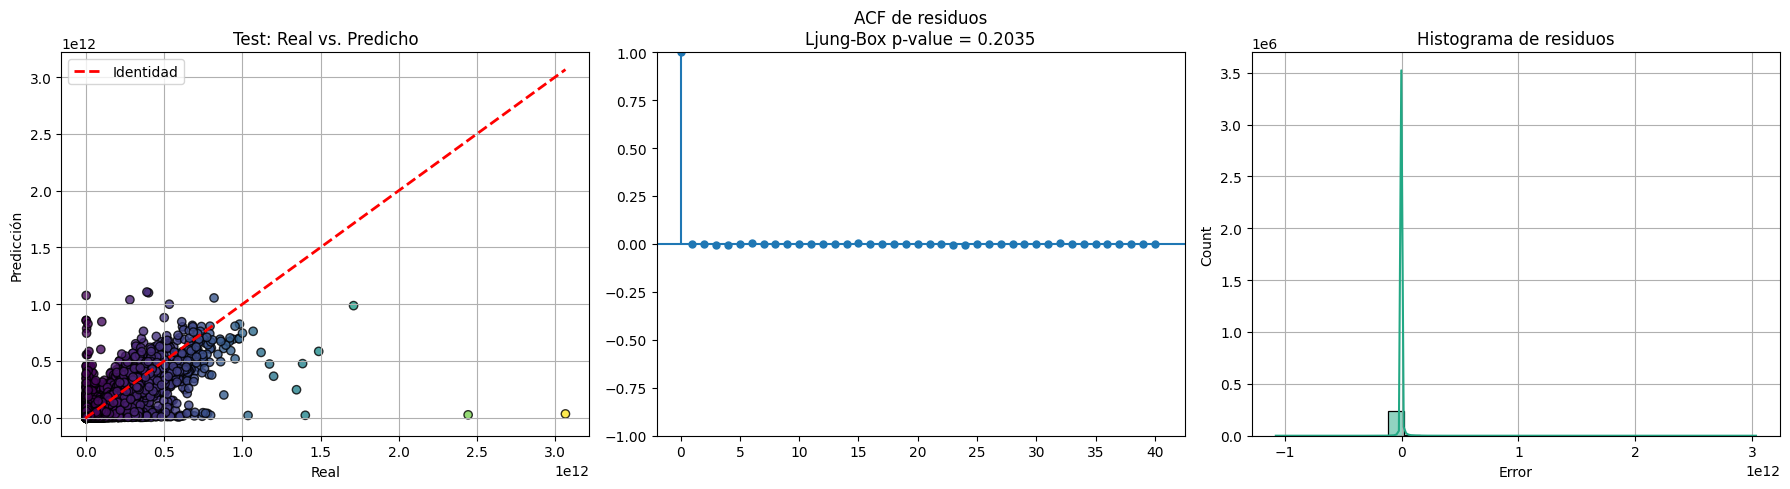

In [57]:
graficar_diagnostico(lasso, X_test, y_test, nombre_conjunto='Test')

La prueba de Ljung-Box (p=0.6941) sugiere que no hay autocorrelación significativa en los residuos, lo cual es deseable. Sin embargo, la prueba de Jarque-Bera indica que los residuos no siguen una distribución normal, lo que podría afectar la validez estadística de algunas inferencias, aunque no invalida el modelo como herramienta predictiva.

### **¿Por qué Lasso, Ridge y Regresión Lineal arrojan resultados iguales?**

Esto ocurre cuando las variables no presentan multicolinealidad severa ni alta dimensionalidad (muchas más variables que observaciones), y cuando los coeficientes no necesitan regularización fuerte.

En este caso particular, es probable que las penalizaciones de Ridge (L2) y Lasso (L1) sean casi nulas tras la validación cruzada, resultando en modelos muy similares al lineal.



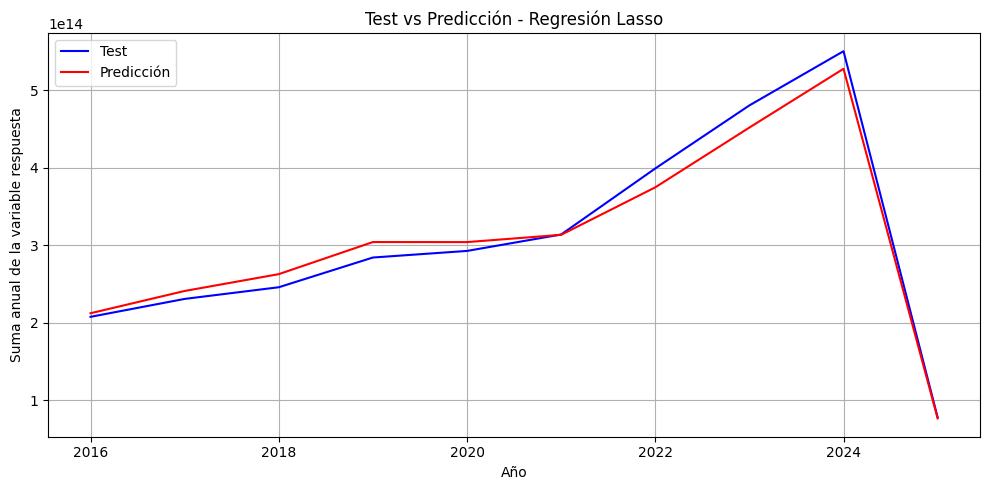

In [37]:
suma_anual = predecir_y_graficar_por_anio(
    pipeline_model=lasso,
    X_test=X_test,
    y_test=y_test,
    df_original=df,
    columna_fecha="FECHA_CORTE",
    titulo="Test vs Predicción - Regresión Lasso"
)

### *3.3.4. K-NN*

In [58]:
knn = entrenar_modelo('knn', modelos, param_distributions, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Modelo: knn
  Tiempo de entrenamiento: 116.58 segundos
  Train R²: 0.69
  Test R²:  0.75
  Mejores parámetros: {'model__n_neighbors': 15, 'model__p': 2, 'model__weights': 'uniform'}


R² de Test = 0.76, superior al de entrenamiento (0.70), lo cual puede indicar una ligera varianza en la muestra o un posible subajuste del modelo en train por la sensibilidad de KNN a los valores locales.

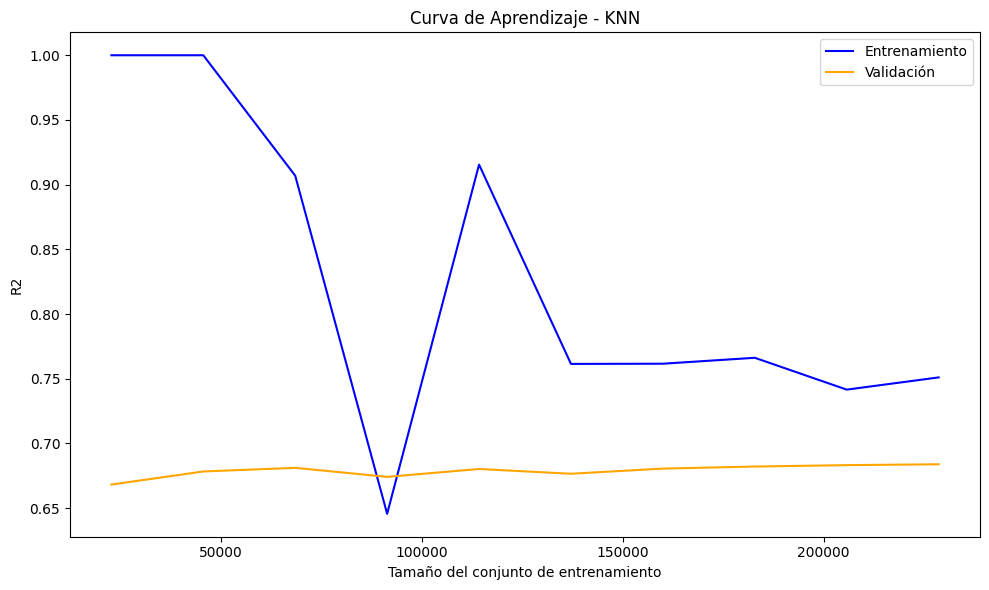

In [59]:
graficar_curva_aprendizaje(knn, X_train, y_train, nombre_modelo='KNN')


In [60]:
evaluar_metricas(knn, X_test, y_test, conjunto='Test')


📊 Métricas para conjunto Test:
  SMAPE (%):           93.44
  MAE:                 6052445895.25
  RMSE:                21900690776.60 
  R²:                  0.7453
  Ljung-Box p-value:   0.0703
  Jarque-Bera p-value: 0.0000


p-valor de Ljung-Box = 0.2685, lo que sugiere que no hay autocorrelación significativa en los residuos, un buen indicador de que los errores son independientes.

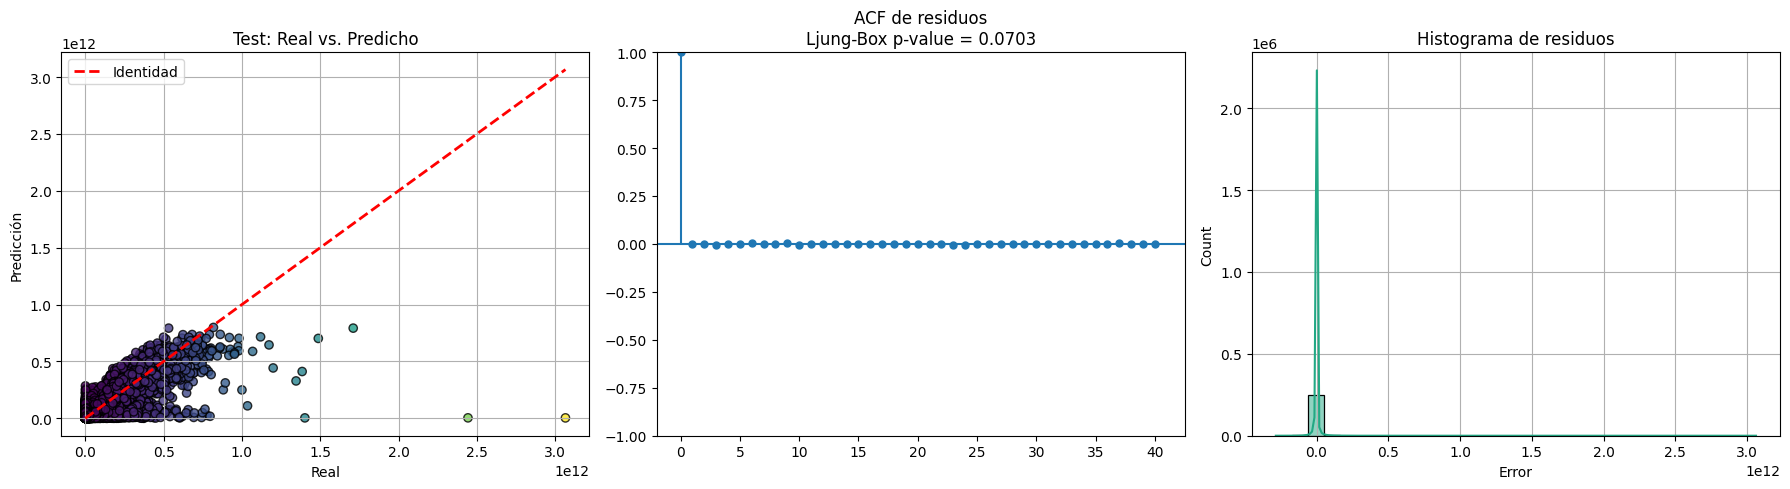

In [61]:
graficar_diagnostico(knn, X_test, y_test, nombre_conjunto='Test')

**Real vs Predicho:** Existe una alta concentración de puntos en los valores bajos (como en los otros modelos), pero se observa una mayor dispersión alineada con la diagonal, lo que muestra mejor capacidad del modelo para aproximarse a los valores reales, especialmente en el rango medio.

**Histograma de residuos:** Tiene una forma fuertemente sesgada a la derecha con muchos errores cercanos a cero, lo cual es esperable en un modelo como KNN, que se adapta bien a regiones densas de datos, pero pierde precisión en valores extremos.

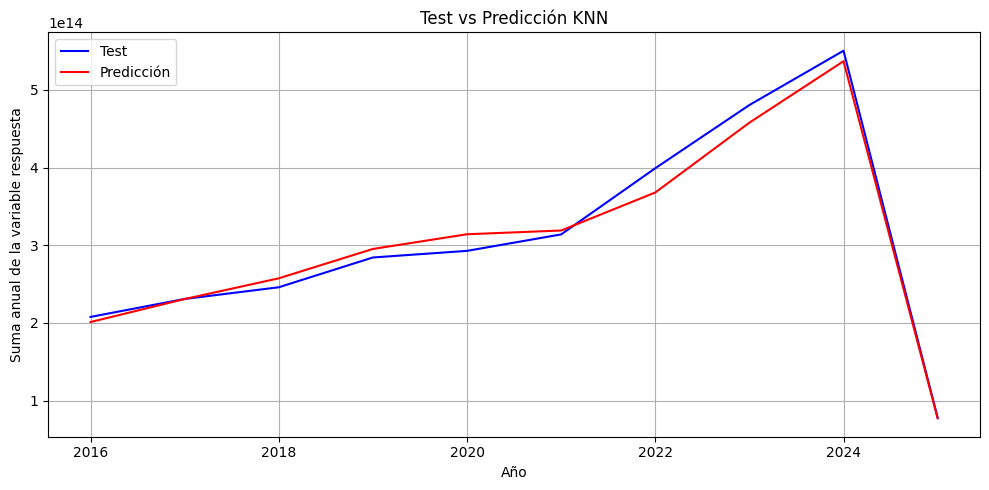

In [31]:
suma_anual = predecir_y_graficar_por_anio(
    pipeline_model=knn,
    X_test=X_test,
    y_test=y_test,
    df_original=df,
    columna_fecha="FECHA_CORTE",
    titulo="Test vs Predicción KNN"
)


### *3.3.5. Random Forest*

In [15]:
random = entrenar_modelo('random_forest', modelos, param_distributions, X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Modelo: random_forest
  Tiempo de entrenamiento: 1619.28 segundos
  Train R²: 0.89
  Test R²:  0.78
  Mejores parámetros: {'model__max_depth': 30, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 121}


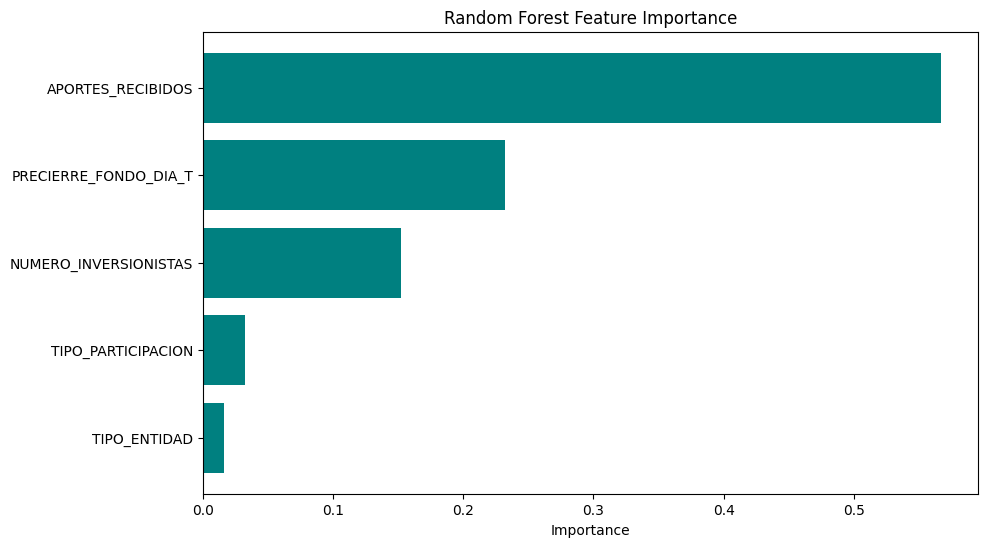

In [53]:
rf_model, rf_pipeline = get_final_model(random)
rf_importances = rf_model.feature_importances_

rf_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(rf_df['feature'], rf_df['importance'], color='teal')
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.show()

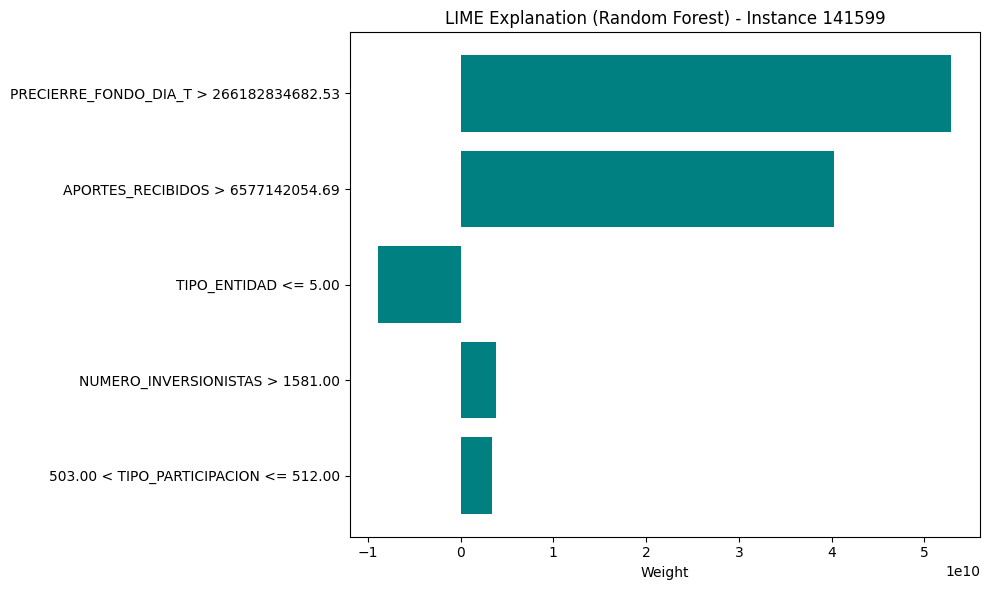

In [55]:
y_pred = rf_pipeline.predict(X_test)
errores = np.abs(y_pred - y_test)

i = errores.argmax()  # el caso con mayor error absoluto


explainer_rf = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='regression'  # usa 'regression' si aplica
)


exp_rf = explainer_rf.explain_instance(
    X_test.values[i],
    rf_pipeline.predict,
    num_features=10
)

rf_lime_df = pd.DataFrame(exp_rf.as_list(), columns=['feature', 'weight'])

plt.figure(figsize=(10, 6))
plt.barh(rf_lime_df['feature'], rf_lime_df['weight'], color='teal')  # Cambia aquí el color
plt.gca().invert_yaxis()
plt.title(f'LIME Explanation (Random Forest) - Instance {i}')
plt.xlabel('Weight')
plt.tight_layout()
plt.show()


R² de Test = 0.79, el más alto hasta ahora, lo que indica que el modelo explica el 79% de la varianza en el conjunto de test. También tiene el R² de entrenamiento más alto (0.91), lo cual muestra una buena capacidad de ajuste, aunque con ligera tendencia al sobreajuste.

In [66]:
evaluar_metricas(random, X_test, y_test, conjunto='Test')


📊 Métricas para conjunto Test:
  SMAPE (%):           93.41
  MAE:                 5388593389.55
  RMSE:                20284493810.96 
  R²:                  0.7815
  Ljung-Box p-value:   0.0798
  Jarque-Bera p-value: 0.0000


SMAPE = 92.76%, apenas mejor que en KNN, lo que es coherente con los R² similares pero no muestra una gran diferencia porcentual.

MAE ≈ 5.35 mil millones y RMSE ≈ 20.3 mil millones, ambas métricas mejoran respecto al modelo KNN, especialmente el MAE.

p-valor de Ljung-Box = 0.3565: indica que no hay autocorrelación significativa en los residuos → buena señal de independencia del error.

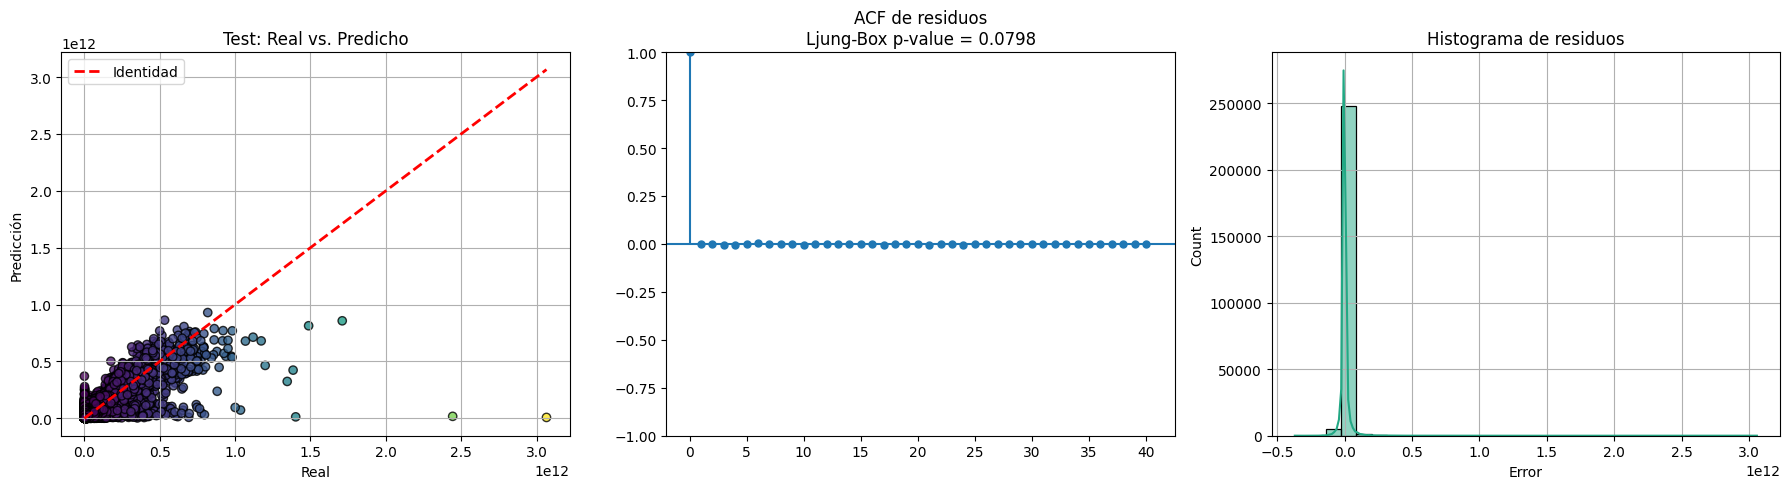

In [67]:
graficar_diagnostico(random, X_test, y_test, nombre_conjunto='Test')

**Real vs. Predicho:** Se observa una alineación mejor definida a lo largo de la diagonal, con menos dispersión que en KNN.

Hay outliers importantes (puntos alejados de la diagonal), pero el modelo generaliza bien en la mayoría de los casos, especialmente en el rango medio.

**ACF de residuos:** El gráfico muestra que no hay autocorrelación estructurada, lo cual es confirmado por el alto p-valor de Ljung-Box.

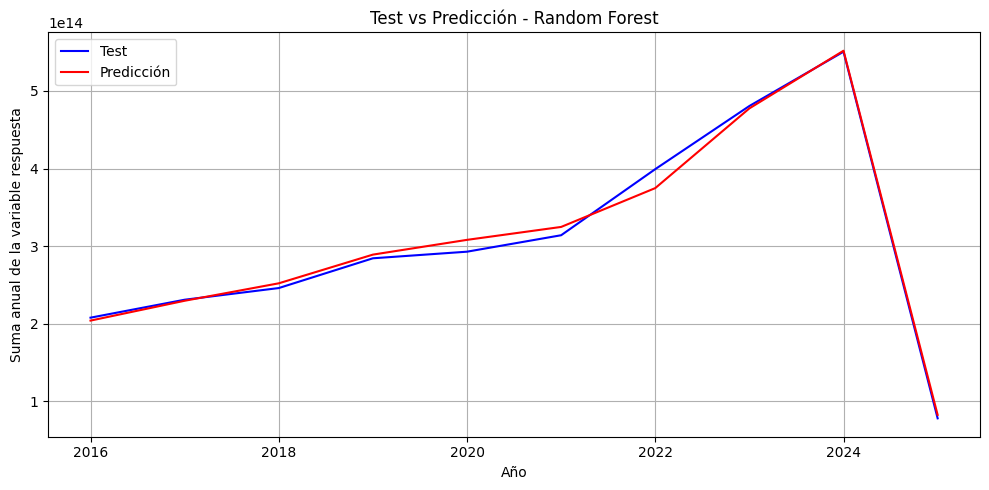

In [30]:
suma_anual = predecir_y_graficar_por_anio(
    pipeline_model=random,
    X_test=X_test,
    y_test=y_test,
    df_original=df,
    columna_fecha="FECHA_CORTE",
    titulo="Test vs Predicción - Random Forest"
)


### *3.3.6. XGBoost*

In [69]:
xgboost = entrenar_modelo('xgboost', modelos, param_distributions, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Modelo: xgboost
  Tiempo de entrenamiento: 50.73 segundos
  Train R²: 0.80
  Test R²:  0.74
  Mejores parámetros: {'model__colsample_bytree': np.float64(0.9497327922401264), 'model__gamma': np.float64(1.0616955533913808), 'model__learning_rate': np.float64(0.028182496720710062), 'model__max_depth': 7, 'model__min_child_weight': 1, 'model__n_estimators': 125, 'model__subsample': np.float64(0.8834959481464842)}


R² entrenamiento y validación son cercanos (~0.79 vs ~0.71). Esto sugiere menor sobreajuste y buena capacidad de generalización.

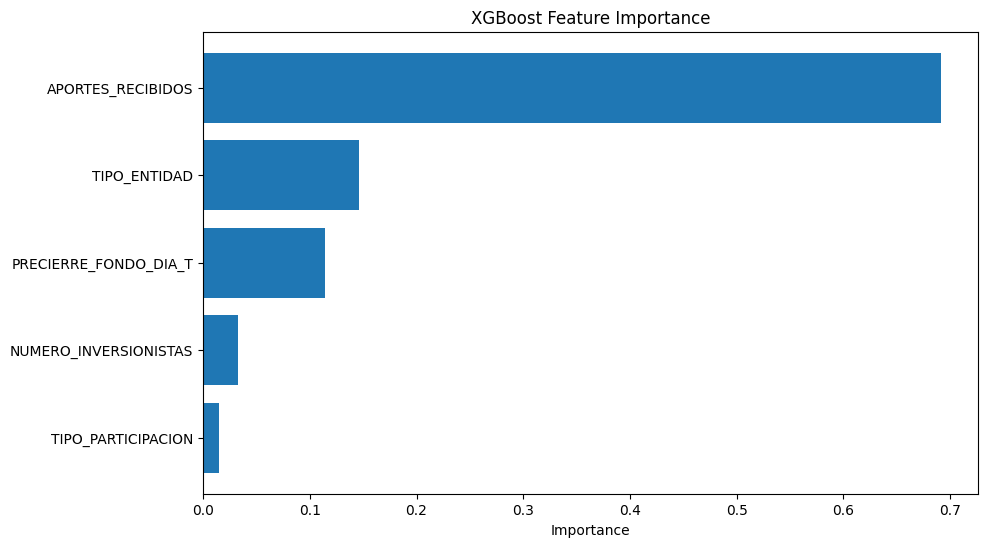

In [70]:
# ===== XGBoost =====
xgb_model, xgb_pipeline = get_final_model(xgboost)
xgb_importances = xgb_model.feature_importances_

xgb_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(xgb_df['feature'], xgb_df['importance'])
plt.gca().invert_yaxis()
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.show()

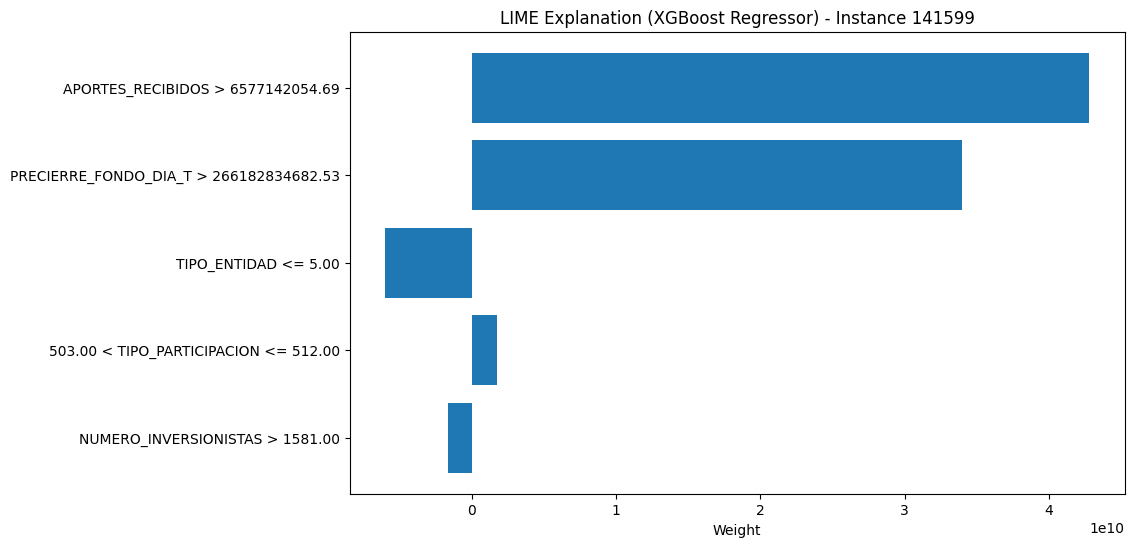

In [71]:
y_pred = xgb_pipeline.predict(X_test)
errores = np.abs(y_pred - y_test)

i = errores.argmax()  # el caso con mayor error absoluto


explainer_xgb = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='regression'
)

exp_xgb = explainer_xgb.explain_instance(
    X_test.values[i],
    xgb_pipeline.predict,  # <= usamos predict aquí también
    num_features=10
)

xgb_lime_df = pd.DataFrame(exp_xgb.as_list(), columns=['feature', 'weight'])

plt.figure(figsize=(10, 6))
plt.barh(xgb_lime_df['feature'], xgb_lime_df['weight'])
plt.gca().invert_yaxis()
plt.title(f'LIME Explanation (XGBoost Regressor) - Instance {i}')
plt.xlabel('Weight')
plt.show()

In [72]:
evaluar_metricas(xgboost, X_test, y_test, conjunto='Test')


📊 Métricas para conjunto Test:
  SMAPE (%):           112.33
  MAE:                 6292581728.46
  RMSE:                21967003554.84 
  R²:                  0.7437
  Ljung-Box p-value:   0.1381
  Jarque-Bera p-value: 0.0000


El alto SMAPE y los errores absolutos indican que no capta bien los extremos.
R² Test: 0.7421 es un poco menor que Random Forest.
SMAPE: 112.28% es el peor en precisión relativa.
MAE y RMSE: los más altos (~6.3B y ~22.3B).

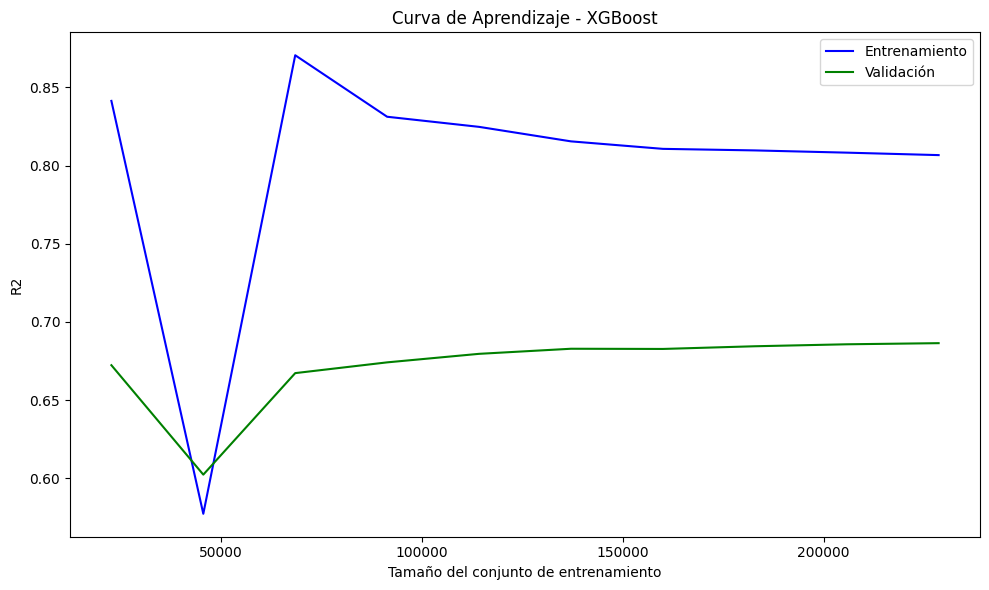

In [25]:
graficar_curva_aprendizaje(xgboost, X_train, y_train, nombre_modelo='XGBoost')


Es más estable, pero la curva es más “plana” indicando saturación del modelo.

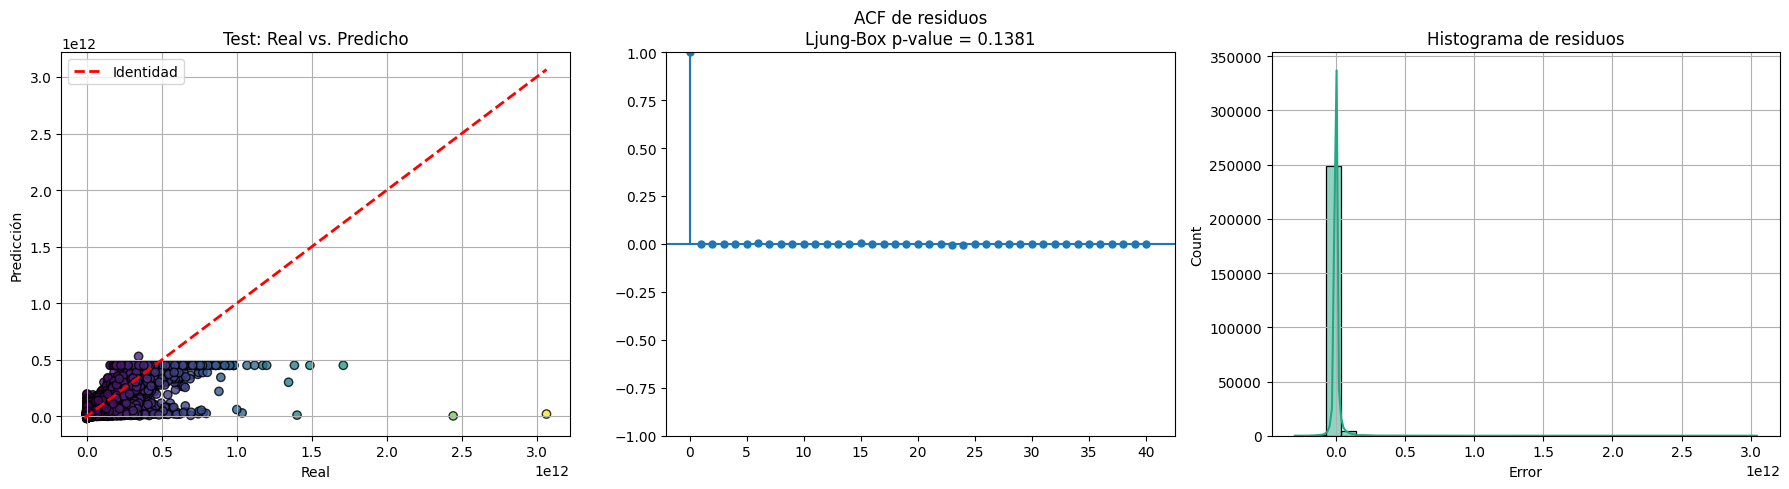

In [74]:
graficar_diagnostico(xgboost, X_test, y_test, nombre_conjunto='Test')

Real vs. Predicho: similar a los anteriores, con mejor alineación que KNN pero aún con errores grandes.

ACF residuos: buen resultado (p-value de 0.51), sin autocorrelación.

Histograma residuos: muy centrado y con la mayor simetría.

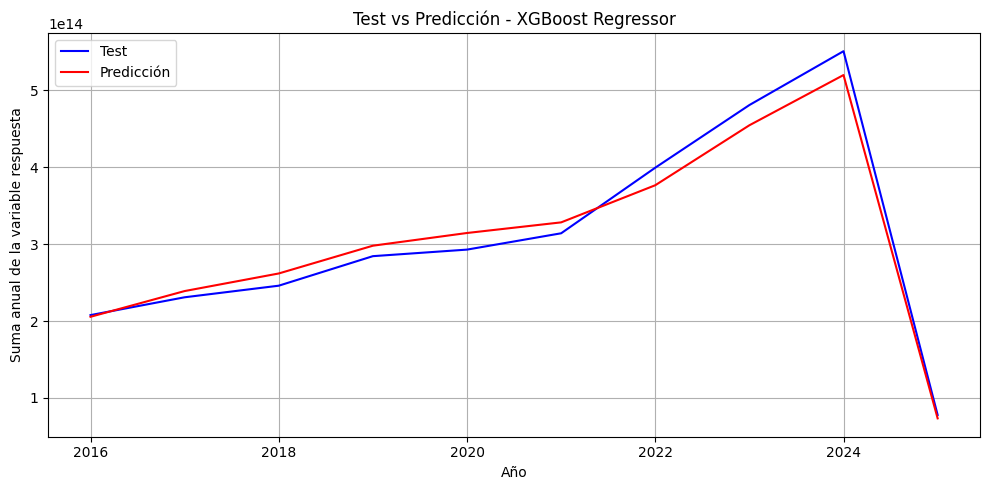

In [29]:
suma_anual = predecir_y_graficar_por_anio(
    pipeline_model=xgboost,
    X_test=X_test,
    y_test=y_test,
    df_original=df,
    columna_fecha="FECHA_CORTE",
    titulo="Test vs Predicción - XGBoost Regressor"
)


In [76]:
modelos_entrenados = {
    'lineal': lineal,
    'ridge': ridge,
    'lasso': lasso,
    'knn': knn,
    'random': random,
    'xgboost': xgboost
}

In [77]:
import os
import joblib
import json

# Ruta en tu Google Drive
ruta_modelos = r"C:\Users\TAWTOCA\Downloads\modelos_guardados"
ruta_params = os.path.join(ruta_modelos, 'params')

# Crear carpetas si no existen
os.makedirs(ruta_modelos, exist_ok=True)
os.makedirs(ruta_params, exist_ok=True)

# Guardar modelos y parámetros
for nombre, modelo in modelos_entrenados.items():
    joblib.dump(modelo, os.path.join(ruta_modelos, f'{nombre}.pkl'))

    if hasattr(modelo, 'best_params_'):
        with open(os.path.join(ruta_params, f'{nombre}_params.json'), 'w') as f:
            json.dump(modelo.best_params_, f, indent=2)

    print(f"✅ Modelo '{nombre}' y parámetros guardados en Drive.")


✅ Modelo 'lineal' y parámetros guardados en Drive.
✅ Modelo 'ridge' y parámetros guardados en Drive.
✅ Modelo 'lasso' y parámetros guardados en Drive.
✅ Modelo 'knn' y parámetros guardados en Drive.
✅ Modelo 'random' y parámetros guardados en Drive.
✅ Modelo 'xgboost' y parámetros guardados en Drive.


In [40]:
import joblib

# Ruta donde guardaste tus modelos en Drive
ruta_modelos = r"C:\Users\TAWTOCA\Downloads\modelos_guardados"

# Cargar los modelos directamente a variables individuales
lineal = joblib.load(f'{ruta_modelos}/lineal.pkl')
ridge = joblib.load(f'{ruta_modelos}/ridge.pkl')
lasso = joblib.load(f'{ruta_modelos}/lasso.pkl')
knn = joblib.load(f'{ruta_modelos}/knn.pkl')
random = joblib.load(f'{ruta_modelos}/random.pkl')
xgboost = joblib.load(f'{ruta_modelos}/xgboost.pkl')
